In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import gc
import os
import math

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

data_path = '/dmc/ml_storage/machine_learning/Final_ML_CBS/'
data_dir = '/dmc/ml_storage/machine_learning/Final_ML_CBS/data/aug/'

from model import *

2023-06-05 20:17:24.572552: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import datetime
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2023-06-05 20:17:26.282439: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-06-05 20:17:26.282455: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-06-05 20:17:26.282959: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-05 20:17:26.294987: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-06-05 20:17:26.297001: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-06-05 20:17:26.297631: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-06-05 20:17:26.297675: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-06-05 20:17:26.317689: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-05 20:17:26.317828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 20:17:26.317961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2023-06-05 20:17:26.317972: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-05 20:17:26.319035: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-05 20:17:26.319061: I tensorflow/stream_executor/platform/

In [4]:
size = 224
input_dim = (size, size, 1)
batch_size = 16

In [5]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator()

datagen = image_generator.flow_from_directory(
        data_dir,
        target_size=(size, size),
        batch_size=1,
        color_mode='grayscale',
        class_mode='categorical',
        shuffle=True)

Found 21399 images belonging to 30 classes.


In [6]:
class_names = list(datagen.class_indices.keys())

In [7]:
class_names = list(datagen.class_indices.keys())
# balance the classes
class_weights = class_weight.compute_class_weight(
                'balanced',
                classes = np.unique(datagen.classes),
                y = datagen.classes)

class_weights = dict(enumerate(class_weights))

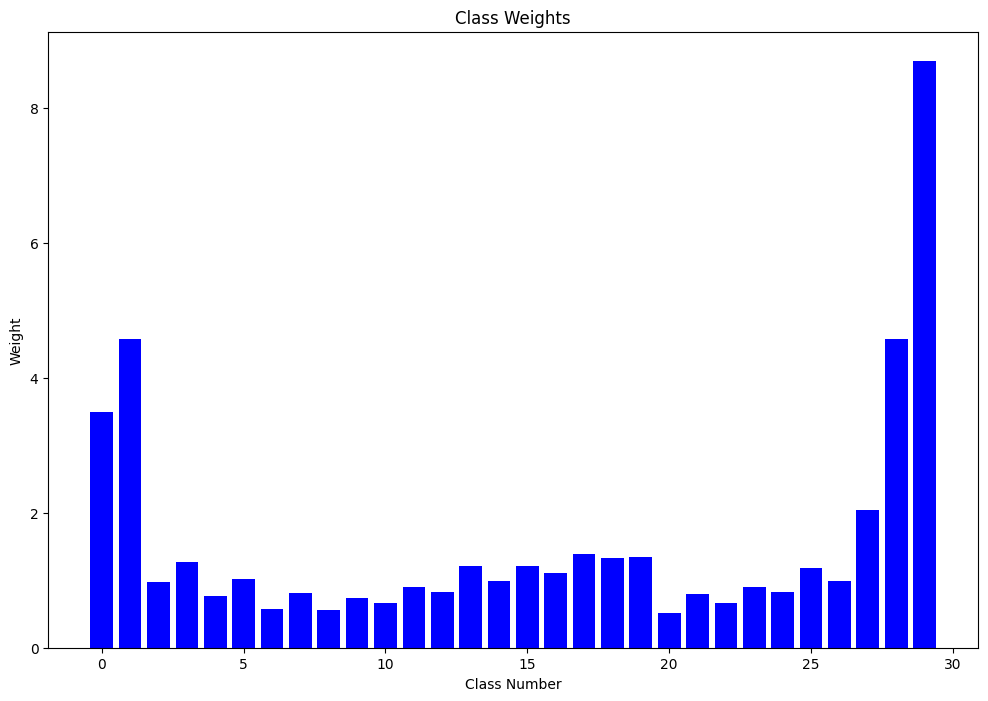

In [8]:
# plot the class distribution
# set the figure size
plt.figure(figsize = (12, 8))
plt.bar(class_weights.keys(), class_weights.values(), color = 'b')
plt.title('Class Weights')
plt.xlabel('Class Number')
plt.ylabel('Weight')
plt.show()

In [9]:
# split the data into training and validation sets
X = []
y = []
for image_batch, label_batch in tqdm(datagen):
    image = image_batch.flatten()
    image = image.reshape(size, size, 1)
    X.append(image)
    label = label_batch.flatten()
    y.append(label)
    if len(X) == len(datagen):
        break

X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)

100%|█████████▉| 21398/21399 [02:09<00:00, 164.83it/s]


<BarContainer object of 30 artists>

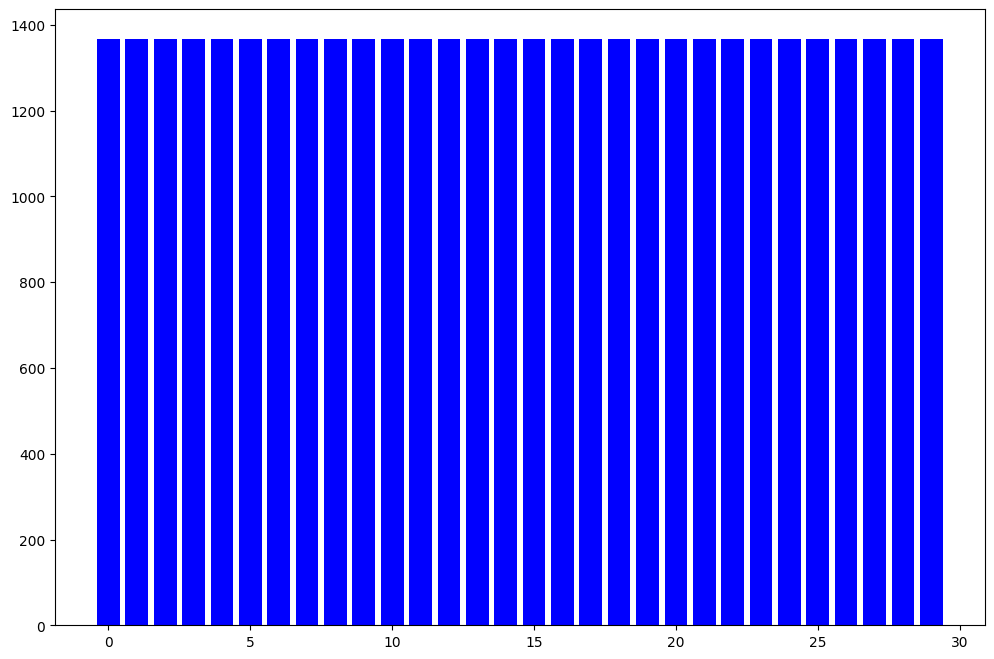

In [10]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X.reshape(-1, size*size), y)
X_train = X_train.reshape(-1, size, size, 1)

# plot the class distribution
# set the figure size
plt.figure(figsize = (12, 8))
# reshape y_train to get the number of instances in each class from the binarized matrix
y_train_plot = np.argmax(y_train, axis = 1)
plt.bar(np.unique(y_train_plot), np.bincount(y_train_plot), color = 'b')


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify = y)

In [12]:
del[X, y]
gc.collect()

4893

In [13]:
#model = single_net(input_dim, 30, 0.0001)
model = single_net(input_dim, 30, 0.0001)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0     

2023-06-05 20:21:43.227114: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 20:21:43.227762: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-05 20:21:43.227901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-05 20:21:43.228053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97Gi

In [14]:
def step_decay(epoch, lr):
    if lr <= 0.00001:
        return 0.00001
    else:
        initial_lrate = 0.001
        drop = 0.5
        epochs_drop = 16.0
        lrate = initial_lrate * math.pow(drop,  
               math.floor((1+epoch)/epochs_drop))
        return lrate

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [15]:
callbacks = [ModelCheckpoint('test.hdf5', verbose=1, save_best_only=True, save_weights_only=True,
                             monitor = 'val_loss'),
             EarlyStopping(monitor = 'val_loss', patience = 32, restore_best_weights = True),
             LearningRateScheduler(step_decay, verbose=1),
             tensorboard_callback]

In [16]:
metrics=['accuracy',
         tf.keras.metrics.TopKCategoricalAccuracy(),
         tf.keras.metrics.Precision(),
         tf.keras.metrics.Recall()]

In [17]:
loss = tf.keras.losses.CategoricalCrossentropy()

In [18]:
model.compile(optimizer=optimizer,
    loss=loss,
    metrics=metrics)

In [19]:
epochs = 256
history = model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size, 
            epochs=epochs, 
            shuffle=True,
            #class_weight=class_weights,
            callbacks=callbacks, 
            use_multiprocessing = True)

2023-06-05 20:21:52.453862: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3435851776 exceeds 10% of free system memory.
2023-06-05 20:21:59.583284: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-05 20:21:59.586031: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4200140000 Hz


Epoch 1/256

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.


2023-06-05 20:22:00.298430: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-05 20:22:00.453719: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-05 20:22:01.676107: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


   2/1070 [..............................] - ETA: 2:44 - loss: 4.9766 - accuracy: 0.0625 - top_k_categorical_accuracy: 0.1094 - precision: 0.0000e+00 - recall: 0.0000e+00   

2023-06-05 20:22:03.291507: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-06-05 20:22:03.291522: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-06-05 20:22:03.291583: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-06-05 20:22:03.428189: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-06-05 20:22:03.429783: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-06-05 20:22:03.436495: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-06-05 20:22:03.439399: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20230605-201726/train/plugins/pro

1070/1070 [==============================] - 160s 146ms/step - loss: 3.9474 - accuracy: 0.0560 - top_k_categorical_accuracy: 0.2402 - precision: 0.0460 - recall: 4.4249e-04 - val_loss: 8.5308 - val_accuracy: 0.0640 - val_top_k_categorical_accuracy: 0.2376 - val_precision: 0.0638 - val_recall: 0.0633

Epoch 00001: val_loss improved from inf to 8.53082, saving model to test.hdf5
Epoch 2/256

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
1070/1070 [==============================] - 154s 144ms/step - loss: 3.6806 - accuracy: 0.0726 - top_k_categorical_accuracy: 0.3206 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 4.3272 - val_accuracy: 0.0638 - val_top_k_categorical_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_loss improved from 8.53082 to 4.32718, saving model to test.hdf5
Epoch 3/256

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
1070/1070 [==============================] - 154s 144ms/step -

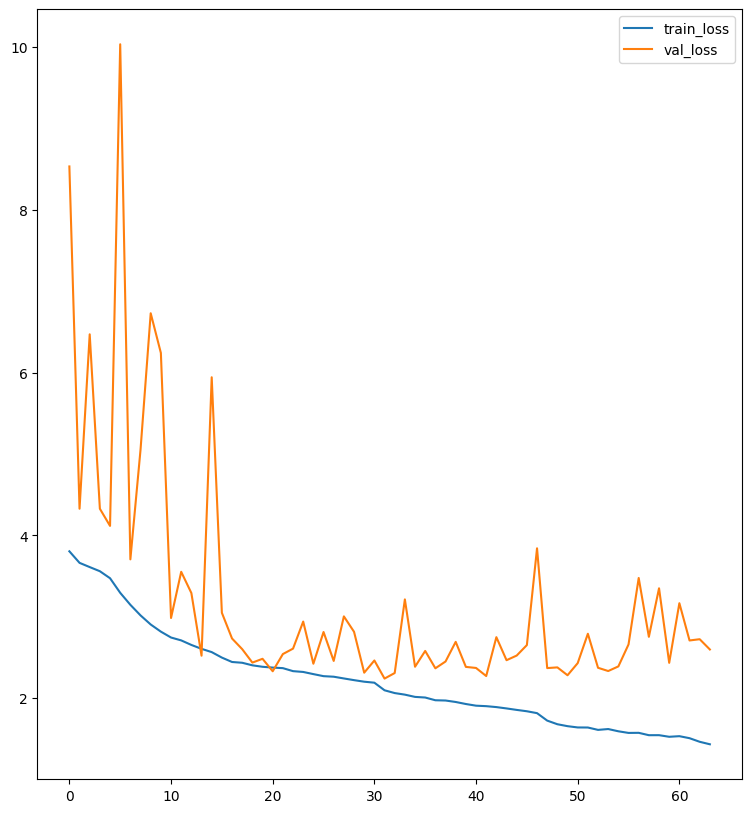

In [20]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [21]:
# Create a table with accuracy, precision, recall and f1-score on the val set
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
# load the best model
model.load_weights('test.hdf5')

# get the predictions
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

# get the true labels
y_true = np.argmax(y_val, axis=1)

# get the classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report = pd.DataFrame(report).transpose()

output = [report, history.history['loss'], history.history['val_loss']]

# conert the output to a dataframe
output = pd.DataFrame(output)
# name the columns
output.index = ['classification_report', 'train_loss', 'val_loss']

output.to_csv('test.csv')

2023-06-05 23:08:15.930008: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
/home/jupyter/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter/minicond

In [22]:
history = pd.DataFrame(history)
history.to_csv('test_history.csv', index = False)

ValueError: DataFrame constructor not properly called!

In [23]:
model.evaluate(X_val, y_val, batch_size = batch_size)

268/268 [==============================] - 10s 37ms/step - loss: 2.2412 - accuracy: 0.2911 - top_k_categorical_accuracy: 0.8904 - precision: 0.2593 - recall: 0.0065


[2.2411715984344482,
 0.2911214828491211,
 0.8904205560684204,
 0.25925925374031067,
 0.006542055867612362]